In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pylab as plt

import chainer
import chainer.links as L
import chainer.functions as F

import varit.random_variables as rv
from varit.models import ae

In [3]:
%matplotlib inline

In [4]:
gpu = 0

# load data

In [5]:
mnist = chainer.datasets.get_mnist()

# define network

In [6]:
class Net1out(chainer.Chain):
    def __init__(self, sensor, hidden, latent):
        super().__init__(
            l1=L.Linear(sensor, hidden),
            l2=L.Linear(hidden, hidden),
            l3=L.Linear(hidden, hidden),
            m0=L.Linear(hidden, latent),
        )

    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = F.relu(self.l3(h))
        m0 = self.m0(h)
        return m0

# define model

In [7]:
sensor_x = 28 * 28
hidden = 1024
zdim_z = 40

encoder = Net1out(sensor_x, hidden, zdim_z)
decoder = Net1out(zdim_z, hidden, sensor_x)

model = ae.AE(encoder, decoder)

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [8]:
if 0 <= gpu:
    model.to_gpu(gpu)
    xp = chainer.cuda.cupy
    chainer.cuda.get_device(gpu).use()
else:
    xp = np

In [9]:
n_epoch = 50
batchsize = 100
N = mnist[0].__len__()

sum_loss_log = []

for epoch in range(0, n_epoch):
    print('epoch', epoch)

    perm = np.random.permutation(N)
    
    sum_loss = 0
    for i in range(0, N, batchsize):
        images, _ = mnist[0].__getitem__([perm[i:i + batchsize]])
        x_batch = chainer.Variable(xp.array(images))
        loss = model.loss(x_batch)
        
        sum_loss += float(loss.data)
        model.zerograds()
        loss.backward()
        optimizer.update()
        
    sum_loss_log.append(sum_loss / N)
    print('train mean loss={}'.format(sum_loss / N))

epoch 0
train mean loss=0.0002492040960739056
epoch 1
train mean loss=0.00012077541110726694
epoch 2
train mean loss=9.951587580144405e-05
epoch 3
train mean loss=8.8656281066748e-05
epoch 4
train mean loss=8.207643612598379e-05
epoch 5
train mean loss=7.690170405743022e-05
epoch 6
train mean loss=7.354211198786895e-05
epoch 7
train mean loss=7.045473175433775e-05
epoch 8
train mean loss=6.831978901755064e-05
epoch 9
train mean loss=6.568695548145721e-05
epoch 10
train mean loss=6.416392620497693e-05
epoch 11
train mean loss=6.259237648143122e-05
epoch 12
train mean loss=6.0678053018637004e-05
epoch 13
train mean loss=5.932067270235469e-05
epoch 14
train mean loss=5.820333796242873e-05
epoch 15
train mean loss=5.7036871338884035e-05
epoch 16
train mean loss=5.614472742502888e-05
epoch 17
train mean loss=5.493248368923863e-05
epoch 18
train mean loss=5.4101091592262186e-05
epoch 19
train mean loss=5.293173948302865e-05
epoch 20
train mean loss=5.2231141086667775e-05
epoch 21
train mean 

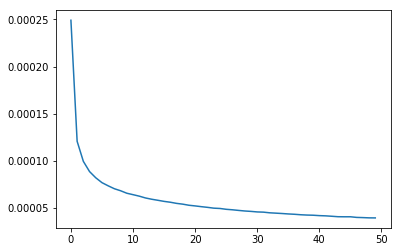

In [10]:
plt.plot(sum_loss_log)

In [11]:
model.to_cpu()
xp = np

In [12]:
model_file_name = 'ae_mnist'

In [13]:
print('save the model')
chainer.serializers.save_npz(model_file_name + '.model', model)
print('save the optimizer')
chainer.serializers.save_npz(model_file_name + '.state', optimizer)

save the model
save the optimizer


In [14]:
print('load the model')
chainer.serializers.load_npz(model_file_name + '.model', model)
print('load the optimizer')
chainer.serializers.load_npz(model_file_name + '.state', optimizer)

load the model
load the optimizer


In [15]:
train_ind = [np.where(mnist[1].__getitem__(range(100))[1] == i)[0][0] for i in range(10)]
images, _ = mnist[1].__getitem__(train_ind)
x_batch = chainer.Variable(xp.array(images))
with chainer.no_backprop_mode(), chainer.using_config('train', False):
    x_hat = model.reconstract(x_batch)

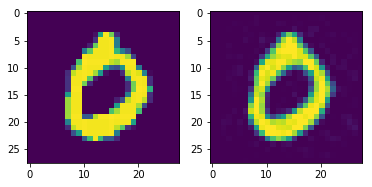

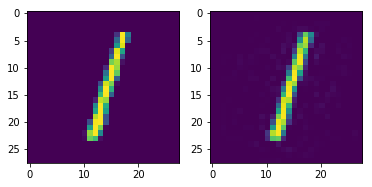

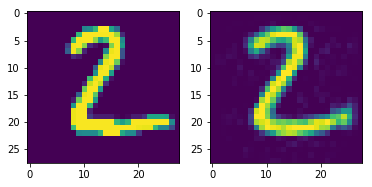

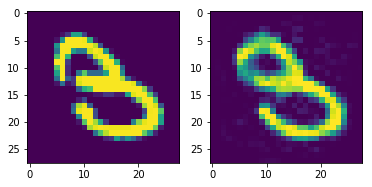

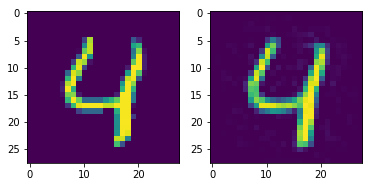

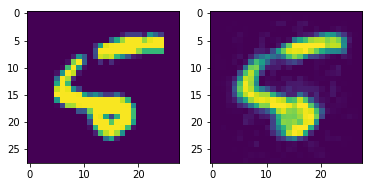

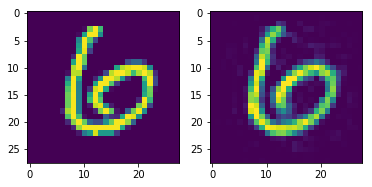

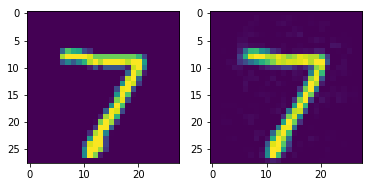

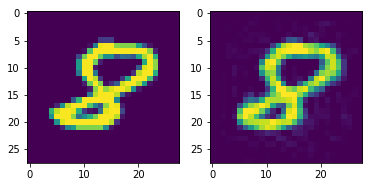

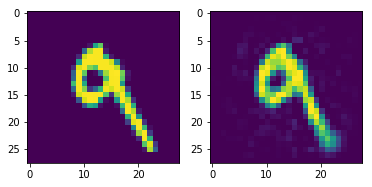

In [17]:
for i in range(len(x_hat)):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(images[i].reshape(28, 28))
    plt.subplot(1, 2, 2)
    plt.imshow(x_hat.data[i].reshape(28, 28), vmin=0, vmax=1)